In [281]:
%load_ext autoreload
%autoreload 2
import sys
path = "/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from events_utils import filter as filt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
# events = np.loadtxt(path + "data/slider-depth/processed/events_refact_34s.txt")
#events = np.loadtxt(path + "data/slider-depth/events.txt")
events_raw = scipy.io.loadmat("../data/stripes.mat")
#events = np.loadtxt("../data/events.txt")

In [283]:
events_rel = events_raw["events"]
events = np.zeros(events_rel.shape)
events[:,0] = events_rel[:,3]
events[:,1:] = events_rel[:,:3]
events[:,0] *= 1e-6

In [403]:
#events = np.loadtxt("../data/events.txt")
time_range = [0.5, 0.65]
idx_range = [np.searchsorted(events[:,0], time_range[0]), np.searchsorted(events[:,0], time_range[1])]
events_t = events[idx_range[0]:idx_range[1], :]

In [404]:
events_t = filt.filter_refract(events_t, 0.1)

# Convolution layer

The goal of the convolution layer is smooth out the events in  the spatial domain. The timing will still be noisy. It should eliminate the gaps and the noise

In [405]:
input_shape = (128, 128)
conv_shape = (2, 2)
result_shape = (int(input_shape[0] / conv_shape[0]), int(input_shape[1] / conv_shape[1]))
conv_count = np.zeros(result_shape)
conv_thresh = conv_shape[0]*conv_shape[1] * 0.2
events_conv = []
for e in events_t:
    x = int(e[1] / conv_shape[1])
    y = int(e[2] / conv_shape[0])
    
    conv_count[y, x] += 1
    
    if conv_count[y, x] >= conv_thresh:
        events_conv.append([e[0], x, y, e[3]])
        conv_count[y, x] = 0

In [406]:
events_conv = np.array(events_conv)

In [407]:
def img_from_events(events):
    img_height = int(events[:,2].max()+1)
    img_width = int(events[:,1].max()+1)
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img

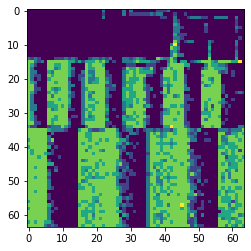

In [408]:
img = img_from_events(events_conv)
plt.imshow(img, interpolation="none")

In [409]:
events_conv

array([[ 0.500003, 46.      , 61.      , -1.      ],
       [ 0.500005, 23.      , 31.      , -1.      ],
       [ 0.50001 , 15.      , 41.      ,  1.      ],
       ...,
       [ 0.649974, 25.      , 46.      ,  1.      ],
       [ 0.649988, 22.      , 22.      ,  1.      ],
       [ 0.649998, 28.      , 32.      , -1.      ]])

In [522]:
events_conv_refract = filt.filter_refract(events_conv, 0.1)

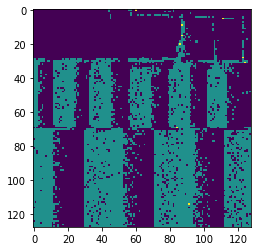

In [523]:
img = img_from_events(events_t)
plt.imshow(img, interpolation="none")

With the refractory period, we can accumulate the last time at one position with the refractory period. NO other events should accour at the first pixel before an event is triggered at the second pixel. 
This implementation would **not work** without the refractory period. 

In [524]:
time_surf = np.zeros(result_shape)
predicted_time = np.full(result_shape, 0.0)
time_diff_map = np.zeros(result_shape)
predicted_time_count = np.zeros(result_shape)
# time_surf = np.zeros(input_shape)
# predicted_time = np.full(input_shape, np.inf)
# time_diff_map = np.zeros(input_shape)
error_list = []

dist = 1

for e in events_conv_refract:
    x = int(e[1])
    y = int(e[2])
    
    if e[3] == 1:
        continue
    
    if x>=result_shape[1] - dist or x < 3:
        continue
    if time_surf[y, x+dist] != 0 and e[0] - time_surf[y, x+dist] <= 3.3:
        #measure the time difference
        time_diff = e[0] - time_surf[y, x+dist]
        #print(predicted_time[y, x])
        
        if predicted_time_count[y, x] > 0 and predicted_time[y, x] != 0.0:
            #measure predicted error
            pred = predicted_time[y, x] / predicted_time_count[y, x]
            print(predicted_time[y, x])
            print("++")
            print(predicted_time_count[y, x])
            print("++")
            print(pred)
            print(e[0])
            
            if np.abs(e[0] - pred) > 0.01 and predicted_time_count[y, x] > 3:
                continue
            
            confidence = np.exp(- 100*np.abs(pred - e[0]))
            if confidence != 0.0:
                print(confidence)
                #print(np.abs(predicted_time[y, x] - e[0]))
                error_list.append(np.abs(pred - e[0]))
            print("-------")
            #prev time difference
            prev_time_diff = time_diff_map[y, x+1]

            #calculate current estimate
            current_estimate = prev_time_diff * confidence + time_diff * (1 - confidence)
            predicted_time[y, x] = 0
            predicted_time_count[y, x] = 0
        else:
            current_estimate = time_diff

        #update all the matrices
        time_diff_map[y, x] = current_estimate
        predicted_time[y, x-1] += e[0] + current_estimate
        predicted_time_count[y, x-1] += 1
        predicted_time[y, x-2] += e[0] + (current_estimate*2)
        predicted_time_count[y, x-2] += 1
        predicted_time[y, x-3] += e[0] + (current_estimate*3)
        predicted_time_count[y, x-3] += 1
        
    time_surf[y, x] = e[0]
error_list = np.array(error_list)

0.5051599999999998
++
1.0
++
0.5051599999999998
0.5040789999999999
0.8975378381587903
-------
0.506658
++
1.0
++
0.506658
0.506784
0.9874790476515605
-------
0.501597
++
1.0
++
0.501597
0.507087
0.577527048761955
-------
0.501721
++
1.0
++
0.501721
0.5072249999999999
0.5767190766061685
-------
0.5097439999999998
++
1.0
++
0.5097439999999998
0.507437
0.7939776235969231
-------
0.508404
++
1.0
++
0.508404
0.507601
0.9228394530188019
-------
0.5019769999999999
++
1.0
++
0.5019769999999999
0.5077349999999999
0.562254884929458
-------
0.5079980000000001
++
1.0
++
0.5079980000000001
0.507768
0.9772624837732709
-------
0.501939
++
1.0
++
0.501939
0.507779
0.5576632463197936
-------
0.508479
++
1.0
++
0.508479
0.509051
0.9444051694432705
-------
0.5122359999999998
++
1.0
++
0.5122359999999998
0.509127
0.7327871509206251
-------
0.5012169999999999
++
1.0
++
0.5012169999999999
0.509288
0.44615002705273954
-------
0.5039949999999999
++
1.0
++
0.5039949999999999
0.5095919999999999
0.57138045227494

0.9353822590821844
-------
1.65566324536766
++
3.0
++
0.5518877484558867
0.5527639999999999
0.9161042099927124
-------
0.5535289999999999
++
1.0
++
0.5535289999999999
0.552786
0.928393134119188
-------
0.5515059999999999
++
1.0
++
0.5515059999999999
0.552868
0.8726680814179031
-------
0.552716
++
1.0
++
0.552716
0.552959
0.9759928679734465
-------
1.0568465779834515
++
2.0
++
0.5284232889917257
0.553017
0.08548869783620293
-------
1.6545827220829237
++
3.0
++
0.5515275740276412
0.553082
0.8560362143634969
-------
0.552426
++
1.0
++
0.552426
0.553102
0.9346342525174478
-------
1.0665447909226546
++
2.0
++
0.5332723954613273
0.553111
0.13753725489723032
-------
1.6592410020969743
++
3.0
++
0.5530803340323248
0.553241
0.9840617825392622
-------
0.5534560000000001
++
1.0
++
0.5534560000000001
0.553369
0.9913377354877867
-------
1.6466822171931756
++
3.0
++
0.5488940723977253
0.553372
0.6390371042141921
-------
0.552388
++
1.0
++
0.552388
0.5535599999999999
0.8894072939153008
-------
1.6558

3.0
++
0.6131628730500228
0.621995
0.41345247897765885
-------
0.614138
++
1.0
++
0.614138
0.6221
0.4510396624491568
-------
0.6155912897531441
++
1.0
++
0.6155912897531441
0.62229
0.5117745798174754
-------
0.6219293303784571
++
1.0
++
0.6219293303784571
0.6224149999999999
0.9525935494538774
-------
0.608942
++
1.0
++
0.608942
0.622678
0.25319381913735023
-------
1.976947462281541
++
3.0
++
0.6589824874271804
0.622791
0.026805485147672507
-------
1.8868058710876932
++
3.0
++
0.6289352903625643
0.623383
0.5739407928908887
-------
1.8637632725937774
++
3.0
++
0.6212544241979258
0.623537
0.7959192203916542
-------
1.8849490568503409
++
3.0
++
0.628316352283447
0.623539
0.620186383020357
-------
1.2389183384182767
++
2.0
++
0.6194591692091383
0.623545
0.6645912565636163
-------
1.8674847433004256
++
3.0
++
0.6224949144334752
0.6237929999999999
0.8782635525416704
-------
0.6199328089131155
++
1.0
++
0.6199328089131155
0.62383
0.6772470806040094
-------
1.8745548965179908
++
3.0
++
0.624851

In [525]:
np.exp(-100*(0.002))

0.8187307530779818

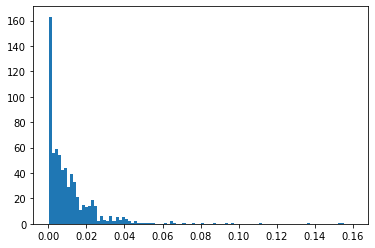

In [526]:
plt.hist(error_list, 100, range=(0.0001, 0.16));

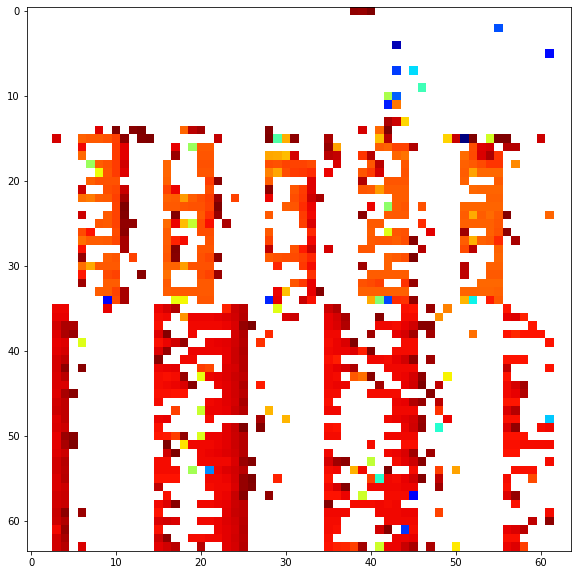

In [527]:
plt.figure(figsize=(10, 10))
time_diff_map_m = np.ma.masked_where(time_diff_map == 0, time_diff_map)
plt.imshow(time_diff_map_m, interpolation="none", cmap="jet_r")

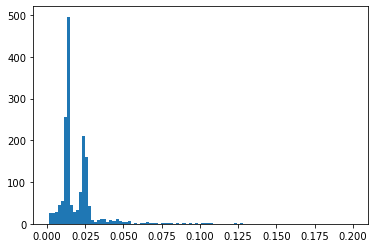

In [484]:
plt.hist(time_diff_map.flatten(), 100, range=(0.001, 0.2));

In [485]:
test = np.ma.masked_where(np.logical_or(time_surf < 0.5, False), time_diff_map_m)

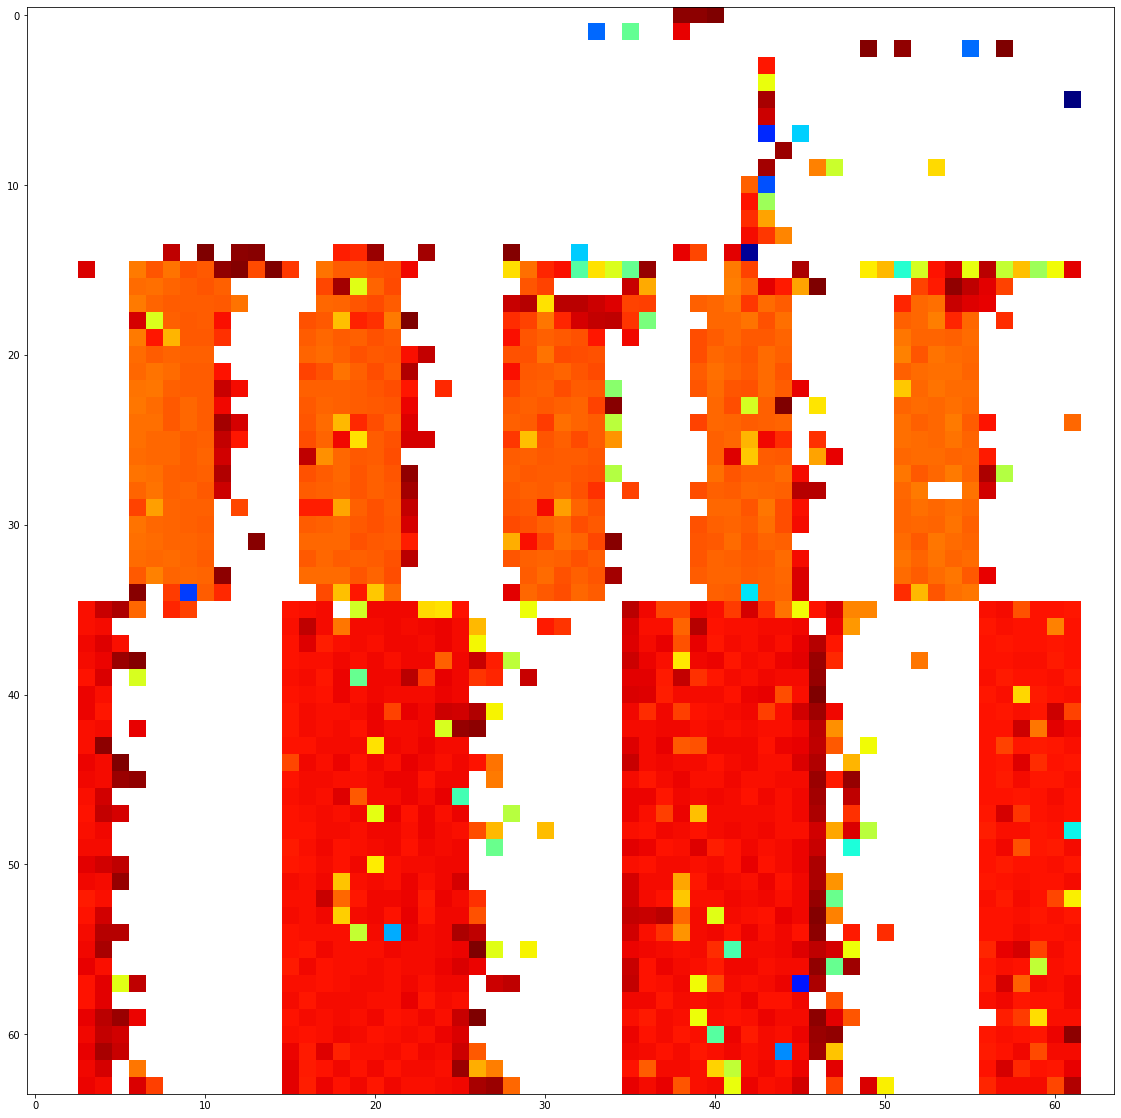

In [486]:
plt.figure(figsize=(20, 20))
plt.imshow(test, cmap="jet_r", interpolation="none")

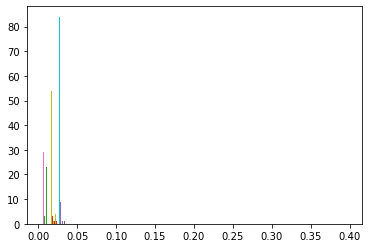

In [222]:
plt.hist(test, range=(0.001, 0.4));

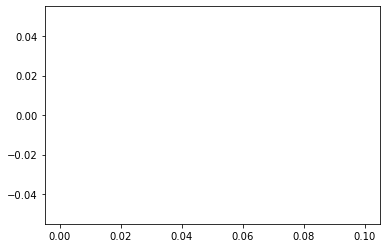

In [459]:
plt.hist(predicted_time.flatten(), 100, range=(0.0001, 0.1));

In [520]:
100 * np.exp(-0.001)

99.9000499833375

In [521]:
0.0015 * 0.005

7.5e-06